In [2]:
import PIL

from __future__ import print_function, division

# from augmentation import *
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torchvision.models.resnet import resnet18, resnet34, resnet50, resnet101
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy
import timm

# data_root = "../datasets/CUB_200_2011/"
# learning_rate = 0.0001
# # batch_size = 128


from models.models import deit_small_patch16_224

In [11]:
from dataset import CUBDataset

from torch.utils.data import random_split

data_root = "./CUB_200_2011"

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)


# write data transform here as per the requirement
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(0.1),
        # transforms.RandomRotation(45),
        # transforms.RandomCrop(224, padding=4),
        # transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        # transforms.RandomAffine(45, (0.3, 0.3), (2, 2)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = CUBDataset(image_root_path=f"{data_root}", transform=train_transform, split="train")
test_dataset = CUBDataset(image_root_path=f"{data_root}", transform=test_transform, split="test")


train_split = int(len(train_dataset) * 0.9)
val_split = len(train_dataset) - train_split
train_ds, val_ds = random_split(train_dataset, [train_split, val_split])

learning_rate = 0.0001
batch_size = 128
# load in into the torch dataloader to get variable batch size, shuffle 
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, num_workers=1, drop_last=True, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=1, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=1, drop_last=False, shuffle=True)

In [17]:
from new_loader import FOODDataset

from torch.utils.data import random_split

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import scipy.io
from PIL import Image
import pandas as pd
from torch.utils.data.dataset import random_split

sz = 448
test_transform=transforms.Compose([
                    transforms.Resize((sz, sz)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])



learning_rate = 0.0001

def food_dataset(data_dir = "/home/sultan.abughazal/Public/foodx-251-dataset",
                 data_transform=transforms.Compose([
                     transforms.Resize((224, 224)),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                 ]),
                    bs=128
                 ):


    split = 'train'
    train_df = pd.read_csv(f'{data_dir}/{split}_labels.csv', names=['image_name', 'label'])
    train_df['path'] = train_df['image_name'].map(lambda x: os.path.join(f'{data_dir}/{split}_set/', x))

    # print(train_df)
    train_df = train_df.drop(0)
    # print(train_df)
    split = 'val'
    val_df = pd.read_csv(f'{data_dir}/{split}_labels.csv', names=['image_name', 'label'])
    val_df['path'] = val_df['image_name'].map(lambda x: os.path.join(f'{data_dir}/{split}_set/', x))
    val_df = val_df.drop(0)
    
    train_dataset = FOODDataset(train_df, transform=data_transform)
    test_dataset = FOODDataset(val_df, transform=test_transform)

    lengths = [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1) + 1]
    torch.manual_seed(0)
    train_set, val_set = random_split(train_dataset, lengths)
    # load in into the torch dataloader to get variable batch size, shuffle
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs, drop_last=True, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=bs, drop_last=True, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, drop_last=False, shuffle=True)

    return train_loader, val_loader, test_loader


In [7]:
train_loader, val_loader, test_loader = food_dataset()

print(len(train_loader), len(val_loader), len(test_loader))

NameError: name 'food_dataset' is not defined

In [ ]:
timm.list_models('*resnetv2*')

In [5]:
model = timm.create_model('resnetv2_50x1_bitm', pretrained=True)

In [6]:
model.head = nn.Sequential(
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Conv2d(2048, 200, kernel_size=(1, 1), stride=(1, 1)),
    nn.Flatten(start_dim=1, end_dim=-1)
)

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
#         for param in model.parameters():
#             param.requires_grad = False
        ct = 0
        for child in model.children():
            ct += 1
            if ct < 4:
                for param in child.parameters():
                    param.requires_grad = False

set_parameter_requires_grad(model, True)

In [8]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [12]:
model

ResNetV2(
  (stem): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (pad): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stages): Sequential(
    (0): ResNetStage(
      (blocks): Sequential(
        (0): PreActBottleneck(
          (downsample): DownsampleConv(
            (conv): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): Identity()
          )
          (norm1): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (act): ReLU(inplace=True)
          )
          (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (act): ReLU(inplace=True)
          )
          (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (norm3)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 409,800 trainable parameters


In [15]:
if torch.cuda.is_available():
    model.cuda()

In [16]:
num_epochs = 50
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
# val_losses = np.array([])
# train_losses = np.array([])
val_losses = []
train_losses = []

val_acc = []
train_acc = []

myfile = open('myfile_cubx_txt', 'w')
myfile.write('Training results: \n')

for epoch in range(num_epochs):
    running_loss = 0
    correct=0
    total=0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        # print(images.shape)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimizes
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (i+1) % 10 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Train Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    train_loss = running_loss / len(train_loader)
    acc = 100.*correct/total
    train_losses.append(train_loss)
    train_acc.append(acc)
    print('Train loss at epoch {} is {:.4f}'.format(epoch+1, train_loss))
    print('Train acc at epoch {} is {:.4f}'.format(epoch+1, acc))
    myfile.write('Train loss at epoch {} is {:.4f}\n'.format(epoch+1, train_loss))
    myfile.write('Train acc at epoch {} is {:.4f}\n'.format(epoch+1, acc))
    myfile.write('---------------------------')
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss = loss / len(val_loader) 
    acc = 100.*correct/total
    val_losses.append(val_loss)
    val_acc.append(acc)
    print('Val loss at epoch {} is {:.4f}'.format(epoch+1, val_loss))
    print('Val acc at epoch {} is {:.4f}'.format(epoch+1, acc))
    myfile.write('Val loss at epoch {} is {:.4f}\n'.format(epoch+1, val_loss))
    myfile.write('Val acc at epoch {} is {:.4f}\n'.format(epoch+1, acc))    
    myfile.write('---------------------------\n')
    myfile.write('---------------------------\n')
    # Decay learning rate
    if (epoch+1) % 10 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

myfile.close()




Epoch [1/50], Step [10/42] Train Loss: 5.3193
Epoch [1/50], Step [20/42] Train Loss: 4.7071
Epoch [1/50], Step [30/42] Train Loss: 4.2347
Epoch [1/50], Step [40/42] Train Loss: 4.0301
Train loss at epoch 1 is 4.8603
Train acc at epoch 1 is 7.5335
Val loss at epoch 1 is 0.9812
Val acc at epoch 1 is 8.6277
Epoch [2/50], Step [10/42] Train Loss: 3.2876
Epoch [2/50], Step [20/42] Train Loss: 2.8706
Epoch [2/50], Step [30/42] Train Loss: 2.6980
Epoch [2/50], Step [40/42] Train Loss: 2.4253
Train loss at epoch 2 is 3.0030
Train acc at epoch 2 is 38.7277
Val loss at epoch 2 is 0.6457
Val acc at epoch 2 is 38.9266
Epoch [3/50], Step [10/42] Train Loss: 2.0700
Epoch [3/50], Step [20/42] Train Loss: 2.1635
Epoch [3/50], Step [30/42] Train Loss: 1.9794
Epoch [3/50], Step [40/42] Train Loss: 1.9046
Train loss at epoch 3 is 1.9908
Train acc at epoch 3 is 60.9747
Val loss at epoch 3 is 0.5158
Val acc at epoch 3 is 60.4959
Epoch [4/50], Step [10/42] Train Loss: 1.4434
Epoch [4/50], Step [20/42] Train

Epoch [27/50], Step [30/42] Train Loss: 0.3470
Epoch [27/50], Step [40/42] Train Loss: 0.3153
Train loss at epoch 27 is 0.3175
Train acc at epoch 27 is 96.8006
Val loss at epoch 27 is 0.2327
Val acc at epoch 27 is 94.9898
Epoch [28/50], Step [10/42] Train Loss: 0.3664
Epoch [28/50], Step [20/42] Train Loss: 0.2951
Epoch [28/50], Step [30/42] Train Loss: 0.3298
Epoch [28/50], Step [40/42] Train Loss: 0.3384
Train loss at epoch 28 is 0.3145
Train acc at epoch 28 is 96.8750
Val loss at epoch 28 is 0.2171
Val acc at epoch 28 is 94.9558
Epoch [29/50], Step [10/42] Train Loss: 0.3536
Epoch [29/50], Step [20/42] Train Loss: 0.2716
Epoch [29/50], Step [30/42] Train Loss: 0.3306
Epoch [29/50], Step [40/42] Train Loss: 0.3312
Train loss at epoch 29 is 0.3104
Train acc at epoch 29 is 96.9494
Val loss at epoch 29 is 0.2044
Val acc at epoch 29 is 95.0747
Epoch [30/50], Step [10/42] Train Loss: 0.2523
Epoch [30/50], Step [20/42] Train Loss: 0.3062
Epoch [30/50], Step [30/42] Train Loss: 0.2708
Epoch

In [17]:

torch.save(model.state_dict(), 'model_checkpoints/model_resnetv2_cub_epoch50.pth')

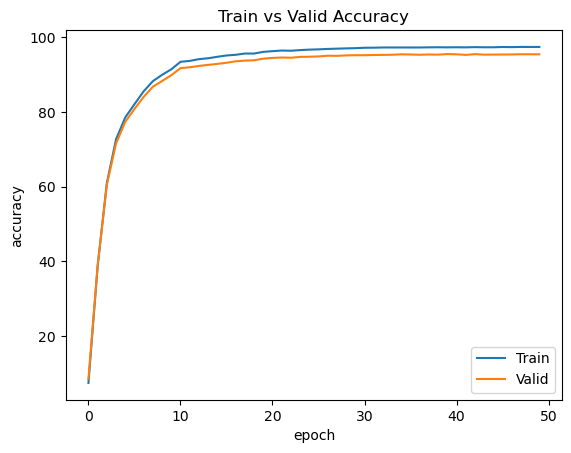

In [18]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()


In [9]:
# model = models.vgg16() # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('model_checkpoints/model_resnetv2_cub_epoch50.pth'))
model

ResNetV2(
  (stem): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (pad): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stages): Sequential(
    (0): ResNetStage(
      (blocks): Sequential(
        (0): PreActBottleneck(
          (downsample): DownsampleConv(
            (conv): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): Identity()
          )
          (norm1): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (act): ReLU(inplace=True)
          )
          (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (act): ReLU(inplace=True)
          )
          (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (norm3)

In [12]:
 # Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 77.37314463237833 %
